# **Escolha dos pólos**

Deve estar claro até aqui que o sucesso do controle depende da escolha adequada do polinômio de malha fechada desejado. Esse polinômio deve ser construído tendo em mente todos os pólos de malha fechada desejados, não apenas os dominantes. 

Isso é importante quando temos um sistema de ordem maior que 2: os pólos que não serão dominantes devem ser escolhidos suficientemente distantes dos candidatos a dominantes.



Uma regra prática é, após escolher os dominantes, escolher os demais como reais, com a parte real de 3 a 5 vezes maior que a parte real dos dominantes. 

Lembre-se, porém, que se o deslocamento desses novos polos for muito grande em relação a posição inicial de malha aberta, os ganhos vão aumentar e consequentemente o sinal de controle vai "puxar" mais energia.



Outra coisa a se ter em mente na hora de escolher pólos de malha fechada são os zeros do sistema. **A realimentação de estados não altera a posição dos zeros**, isto é, se você não cancelar os zeros de malha aberta, eles permanecerão na mesma posição em malha fechada. 

Se os zeros (em malha aberta ou fechada, tanto faz) estiverem próximos dos pólos dominantes em malha fechada, a dinâmica que você projetou não irá funcionar (normalmente o overshoot será mais alto do que o projetado).

Uma forma de lidar com isso é posicionar um pólo extra sobre o zero que está atrapalhando seu projeto, mas **apenas se o zero for estável!** O cancelamento vai criar um pequeno problema de controlabilidade, mas desde que tudo seja estável, não haverá problema. 

Note que devido às incertezas e os arredondamentos de projeto, podemos ter que fazer novas escolhas de polos até achar uma combinação que se ajuste ao que precisamos.

## **Exemplo**
<p align="center">
<img src="Ex7.20.svg" width="80%">
</p>

Resolvemos no código abaixo

In [1]:
import control as ct
import numpy as np
from escrever import *
from IPython.display import display, Math

esc = escrever()

In [2]:
# Sistema
A = np.array([  [0, 2, 0, 0, 0],
                [-.1, -.35, .1, .1, .75], 
                [0, 0, 0, 2, 0],
                [.4, .4, -.4, -1.4, 0],
                [0, -.03, 0, 0, -1]     ],dtype=float)
B = np.array([[0],[0],[0],[0],[1]])
C = np.array([[1,0,0,0,0]])
D = np.array([[0]])
esc.sist(A,B,C,D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
# Polos desejados
xi = 0.707
wn = 1/1.15
p = -xi*wn+1j*wn*np.sqrt(1-xi**2)
esc.polos(xi,wn)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# Polos de malha fechada desejados. 
polos_dom = np.array([[p, np.conjugate(p)]])
polos_extras = np.array([[np.real(p)*4]*3])
polos_mf = np.block([polos_dom,polos_extras])
display(Math(esc.mat(polos_mf.T.round(decimals=4))))

<IPython.core.display.Math object>

In [5]:
# Faz a alocação de polos
K = ct.acker(A,B,polos_mf[0,:])
display(Math(r'\mathbf{K} = ' + esc.mat(K.round(decimals=4))))

<IPython.core.display.Math object>

**Os valores são um pouco diferentes do livro. Tente descobrir a razão**

A seguir vamos calcular o ganho da referência e depois definir o sistema em malha fechada para estudar a resposta da saída e do sinal de controle

In [6]:
# Cálculo do ganho de referência. 
# Mesmo do anterior, mas readequado para as dimensões do problema
n = A.shape[0]
M = np.block([[A,B],[C,D]])
v = np.block([[np.zeros((n,1))],[1]])

NN = np.linalg.solve(M, v)

Nx = NN[0:n]
Nu = NN[-1]
N = Nu+K@Nx
display(Math(esc.mat(M) + r'\mathbf{N} = ' + esc.mat(v)))
str = r'\mathbf{N} = ' + esc.mat(NN)
str += r'\Rightarrow\quad \mathbf{N_x} = ' + esc.mat(Nx)
str += r',\quad N_u = ' + f'{Nu[0]}'
display(Math(str))
display(Math(r'N = ' + '{:1.5}'.format(N[0,0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
# Sistema em malha fechada
Amf = A - B@K
Bmf = B*N
Cmf = C
Dmf = np.zeros((1,1))

sys = ct.ss(Amf,Bmf,Cmf,Dmf)
esc.sist(Amf.round(decimals=4),Bmf.round(decimals=4),Cmf.round(decimals=4),Dmf)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
# Relatório final
Tab = ct.damp(sys)
print('')
print('Zeros: ')
Z = ct.zeros(sys)
Z = Z.reshape((Z.size,1))
display(Math(esc.mat(Z.round(decimals=4))))
print('')
print('Step Info')
ct.step_info(sys)

_____Eigenvalue______ Damping___ Frequency_
    -2.459                     1      2.459
    -2.459 +2.17e-05j          1      2.459
    -2.459 -2.17e-05j          1      2.459
   -0.6148    +0.615j      0.707     0.8696
   -0.6148    -0.615j      0.707     0.8696

Zeros: 


<IPython.core.display.Math object>


Step Info


{'RiseTime': 1.5652270471069318,
 'SettlingTime': 4.975185971161319,
 'SettlingMin': 0.9110962604717889,
 'SettlingMax': 1.0339602896750193,
 'Overshoot': 3.3960289675019295,
 'Undershoot': 0,
 'Peak': 1.0339602896750193,
 'PeakTime': 3.689463753894911,
 'SteadyStateValue': 1.0}

In [9]:
# Simulação
resp = ct.step_response(sys)

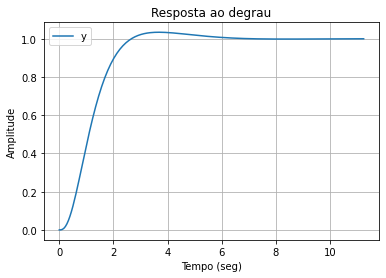

In [10]:
# Gráfico da resposta temporal
from matplotlib import pyplot as plt
resp.y.shape
resp.t.shape
plt.plot(resp.t,resp.y[0,0,:])
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('Amplitude')
plt.title('Resposta ao degrau')
plt.legend('y(t)')

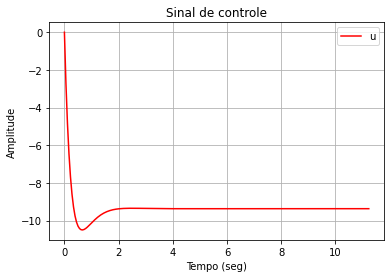

In [11]:
# Cálculo e plotagem do sinal de controle
u = -K@resp.states
u[0,:].shape
plt.plot(resp.t,u[0,:],'r')
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('Amplitude')
plt.title('Sinal de controle')
plt.legend('u(t)')
